## Commiting

To commit changes to this notebook, save, then run the following cell.
It will push to the changes to https://github.com/wcyuan/opencv_ipynotebook

In [2]:
#commit()

In [3]:
%matplotlib inline

---

## Kernel Restart

If you have to restart the Kernel, run the cells in this section to get going again.  This will:

 * import necessary modules
 * define some important functions
 * load tennis.mp4 into the array frames

In [4]:
import cv2
import datetime
import io
import math
import numpy
import pylab
import PIL
import scipy
import time
import urllib2
from pylab import *
import scipy.signal

#
# http://stackoverflow.com/questions/12689304/ctypes-error-libdc1394-error-failed-to-initialize-libdc1394
#
# To fix the following error:
# libdc1394 error: Failed to initialize libdc1394
#
# Run this:
# sudo ln /dev/null /dev/raw1394
#

video_file="/home/murali/ipynb/video/2015-08-08 09.43.50.mov"

In [5]:
def run(cmd):
    import subprocess
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return proc.communicate()

In [6]:
def commit(msg="Periodic Update"):
    print run(["git", "commit", "-m", msg, "2015-07-29 Images.ipynb"])
    # Pushes to https://github.com/wcyuan/opencv_ipynotebook
    print run(["git", "push"])

In [7]:
# Read an image from a url and display it
# http://stackoverflow.com/a/12020860/1808109
def show_url(url):
    fd = urllib2.urlopen(url)
    image_file = io.BytesIO(fd.read())
    image = PIL.Image.open(image_file)
    pylab.imshow(array(image))
    return image

In [8]:
# Appears to return UTC time
def ts(*args):
    now = datetime.datetime.now()
    ts = datetime.datetime.strftime(now, "%Y%m%d %H:%M:%S.%f")
    return "[{0}] {1}".format(ts, " ".join(str(a) for a in args))
ts("test")

'[20150828 11:08:01.062231] test'

In [9]:
# This reads all the frames of tennis.mp4 info a numpy array.
def read_video_file(filename, max_frame=10000):
    # setup video capture
    cap = cv2.VideoCapture(filename)
    
    frames = []
    # get frame, store in array
    for ii in xrange(max_frame):
        #print ts("Frame:", ii)
        ret, im = cap.read()
        if not ret:
            break
        frames.append(im)
    cap.release()
    print ts("Converting to np array")
    frames = array(frames)
    
    # check the sizes
    print frames[-1].shape
    print frames.shape
    print ts("Done")

    return frames

In [10]:
#
# tennis.mp4 is a copy of https://www.youtube.com/watch?v=8MmC8HIC44o
# It's a video of several tennis serves, with speeds.
#
frames = read_video_file(video_file)

# takes a minute to run, most of the time is spent converting to a numpy array.
# Here's the relevant output:
# Shape of a single frame: (144, 192, 3)
# Shape of the whole video (382 frames): (382, 144, 192, 3)


[20150828 11:08:02.496605] Converting to np array
(320, 432, 3)
(1222, 320, 432, 3)
[20150828 11:08:02.574604] Done


---

## Images

This section is where I started playing around with images, as per

http://programmingcomputervision.com/downloads/ProgrammingComputerVision_CCdraft.pdf


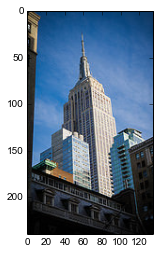

In [11]:
url = "https://farm9.staticflickr.com/8574/16863538942_ecf0f76c40_n.jpg"
image = show_url(url)

<matplotlib.contour.QuadContourSet instance at 0x7fe6a21f84d0>

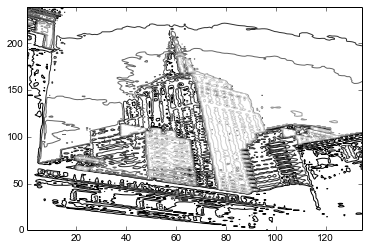

In [12]:
# create a new figure
#pylab.figure()
# don’t use colors
pylab.gray()

# show contours with origin upper left corner
pylab.contour(array(image.convert("L")), origin="image")

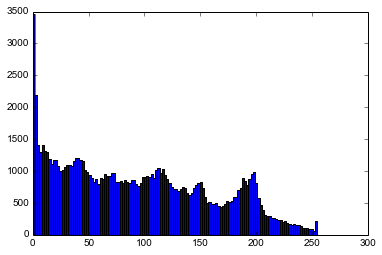

In [13]:
hist(array(image).flatten(),128)
show()

In [14]:
im = array(image)
print im.shape, im.dtype

im = array(image.convert("L"), "f")
print im.shape, im.dtype


(240, 135, 3) uint8
(240, 135) float32


In [15]:
# https://github.com/jesolem/PCV/blob/master/pcv_book/imtools.py

def histeq(im,nbr_bins=256):
    """ Histogram equalization of a grayscale image. """
    # get image histogram
    imhist,bins = histogram(im.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize
    # use linear interpolation of cdf to find new pixel values
    im2 = interp(im.flatten(),bins[:-1],cdf)
    return im2.reshape(im.shape), cdf

In [16]:
# https://github.com/jesolem/PCV/blob/master/pcv_book/pca.py

def pca(X):
    """    Principal Component Analysis
        input: X, matrix with training data stored as flattened arrays in rows
        return: projection matrix (with important dimensions first), variance and mean.
    """
    
    # get dimensions
    num_data,dim = X.shape
    
    # center data
    mean_X = X.mean(axis=0)
    X = X - mean_X
    
    if dim>num_data:
        # PCA - compact trick used
        M = dot(X,X.T) # covariance matrix
        e,EV = linalg.eigh(M) # eigenvalues and eigenvectors
        tmp = dot(X.T,EV).T # this is the compact trick
        V = tmp[::-1] # reverse since last eigenvectors are the ones we want
        S = sqrt(e)[::-1] # reverse since eigenvalues are in increasing order
        for i in range(V.shape[1]):
            V[:,i] /= S
    else:
        # PCA - SVD used
        U,S,V = linalg.svd(X)
        V = V[:num_data] # only makes sense to return the first num_data
    
    # return the projection matrix, the variance and the mean
    return V,S,mean_X


def center(X):
    """    Center the square matrix X (subtract col and row means). """
    
    n,m = X.shape
    if n != m:
        raise Exception('Matrix is not square.')
    
    colsum = X.sum(axis=0) / n
    rowsum = X.sum(axis=1) / n
    totalsum = X.sum() / (n**2)
    
    #center
    Y = array([[ X[i,j]-rowsum[i]-colsum[j]+totalsum for i in range(n) ] for j in range(n)])
    
    return Y

---

## Tennis

This part is for exploring the actual problem of analysing tennis serve speeds.

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x650 at 0x7FE6A20F9B48>

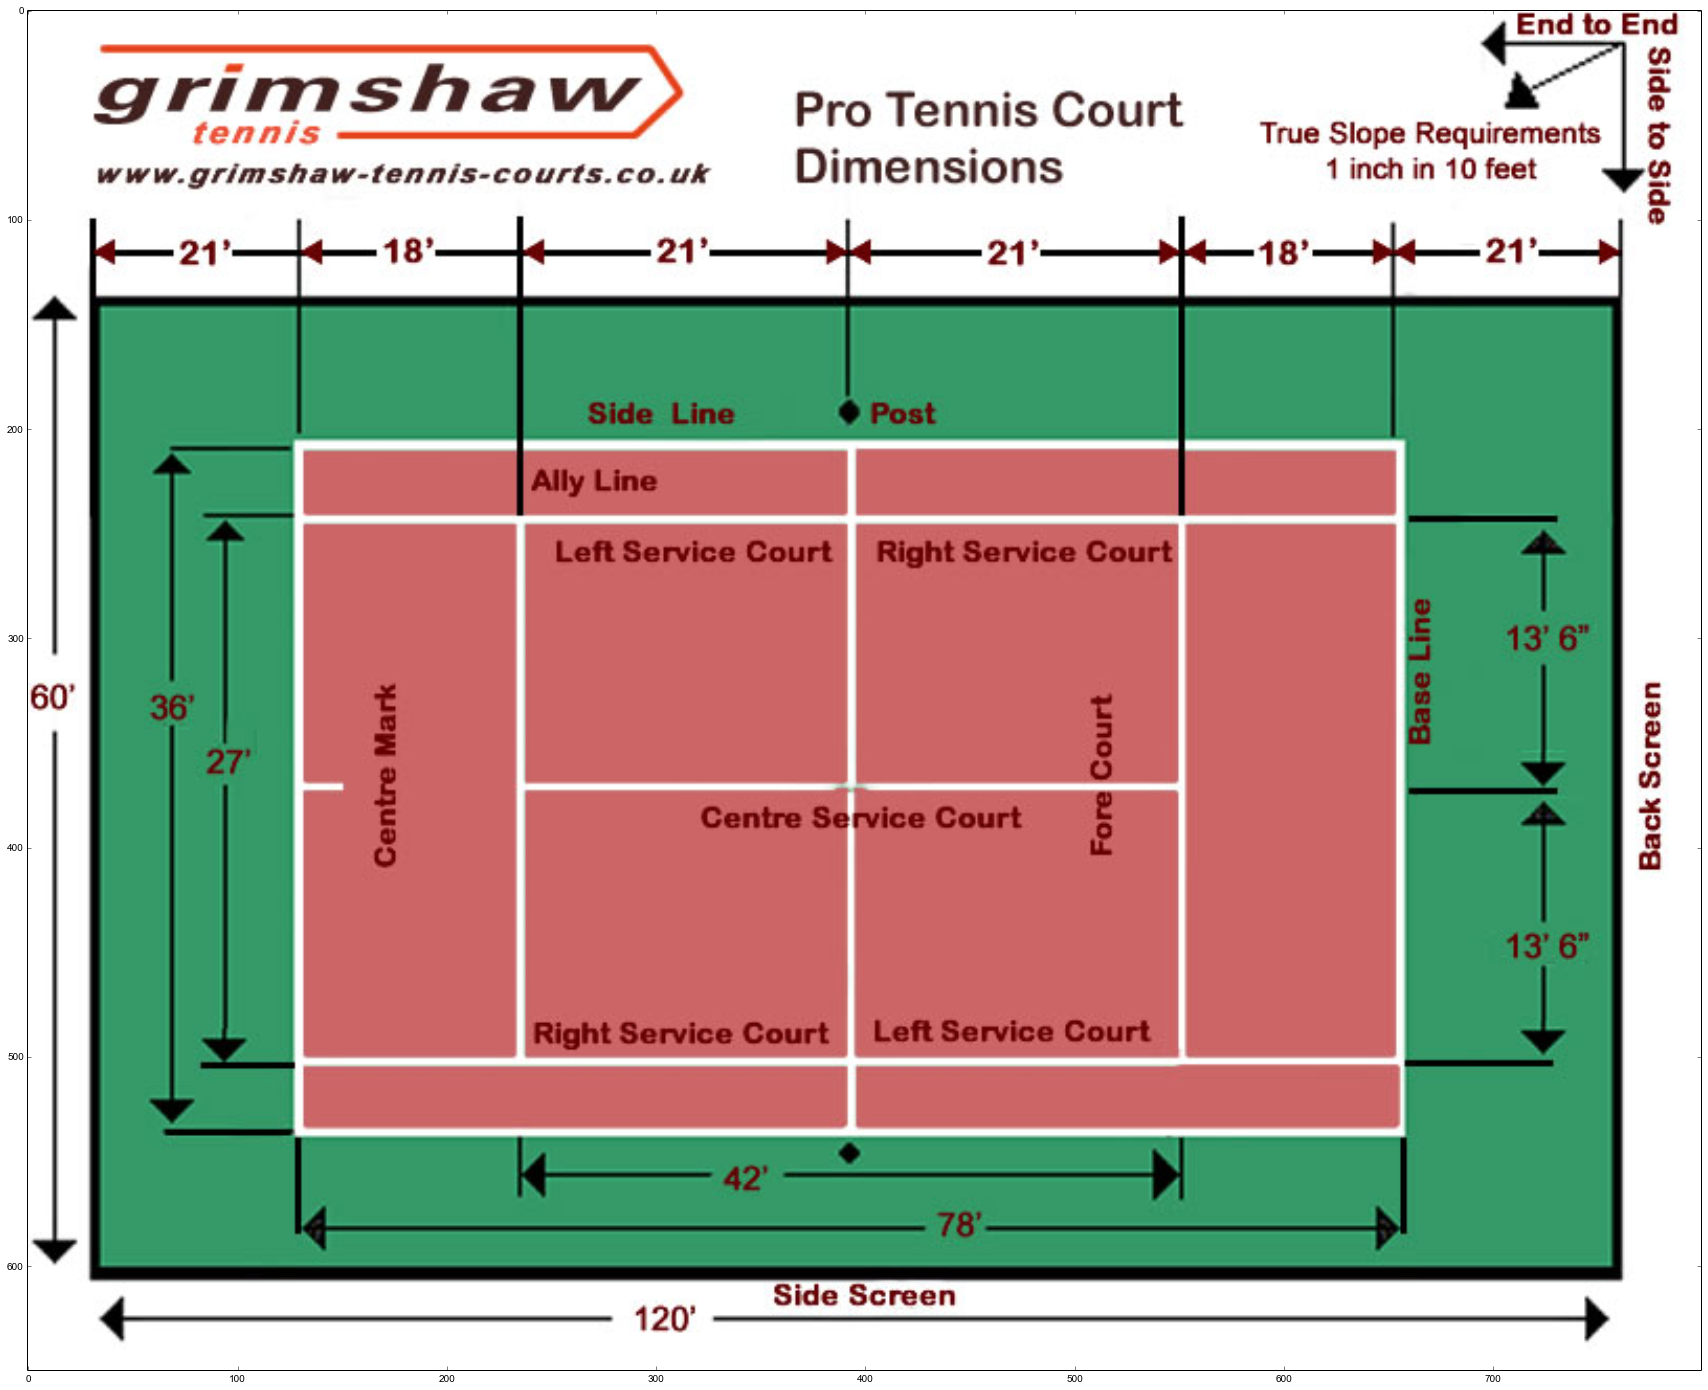

In [17]:
# For information, here are the dimensions of a tennis court.
#
court = "http://www.grimshaw-tennis-courts.co.uk/images/Tennis-Court-Dimensions.jpg"
pylab.figure(figsize=(30.0, 30.0))
show_url(court)


In [18]:
cap = cv2.VideoCapture(video_file)

In [19]:
cap.isOpened()

True

In [20]:
ret, im = cap.read()

In [21]:
print im.shape
ii=40

(320, 432, 3)


40


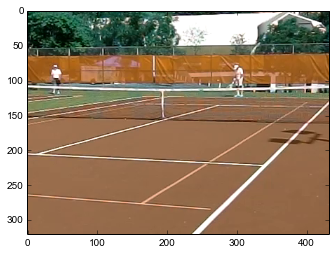

In [22]:
# video metadata from avconv:
#
#Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'tennis.mp4':
#  Metadata:
#    major_brand     : dash
#    minor_version   : 0
#    compatible_brands: iso6avc1mp41  
#    creation_time   : 2013-08-25 02:46:14
#  Duration: 00:00:25.15, start: 0.000000, bitrate: 112 kb/s
#    Stream #0.0(und): Video: h264 (Constrained Baseline), yuv420p, 192x144, 110 kb/s, 15 fps, 15 tbr, 90k tbn, 30 tbc
#    Metadata:
#      creation_time   : 2013-08-25 02:46:14
#[libx264 @ 0x900f1a0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2
#[libx264 @ 0x900f1a0] profile High, level 1.1
#[libx264 @ 0x900f1a0] 264 - core 142 r2389 956c8d8 - H.264/MPEG-4 AVC codec - Copyleft 2003-2014 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=1 lookahead_threads=1 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=15 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.25 aq=1:1.00
#
# In particular, it's 15 frames / second
#
# I don't yet know how to get the frames / second info from opencv, if it's even possible.
#
# First serve:
# ball is hit at frame 33
# hits the ground at frame 42
# 79 mph
#
# Second serve:
# ball is hit at frame 99
# hits the ground at frame 109
# 77 mph
#
# Frame 138 -- a new scene (same view)
# Third serve:
# ball is hit at frame 163, or perhaps between 162-163
# hits the ground at frame 169
# 95 mph
#
# Note, most frames have multiple ball images, or maybe the ball is an elogated thing, so you
# can sort of see the direction it's traveling in
#
# This video is very steady, it must have been taken with a tripod.
#
print ii
pylab.imshow(frames[ii])
ii += 1


In [23]:
# The distance from baseline to service line is 60' (18 + 21 + 21)
#
# quick_and_dirty computes speed if you assume every serve just goes from the baseline
# to the opposite service line and travels perfectly perpendicular to the baseline
#
# So a quick-and-dirty estimate of speed is
#
# (60 feet / N frames) / (5280 feet-per-mile) * 15 fps * 3600 seconds-per-hour = 68.18 mph
#
def quick_and_dirty(frames, fps=15, feet=60):
    # multiply by 1.0 to force floats
    feet_per_frame = 1.0 * feet / frames
    feet_per_second = feet_per_frame * fps # frames_per_second
    feet_per_hour = feet_per_second * 3600.0 # seconds per hour
    miles_per_hour = feet_per_hour / 5280.0 # feet per mile
    return miles_per_hour

#     frames  actual   estimate
print      9,     79,  quick_and_dirty(9, feet=61.5)   # = 69.89
print     10,     77,  quick_and_dirty(10, feet=61.5)  # = 62.9
print    6.5,     95,  quick_and_dirty(6.5) # = 94.4


9 79 69.8863636364
10 77 62.8977272727
6.5 95 94.4055944056


8 76.7045454545
9 68.1818181818
10 61.3636363636


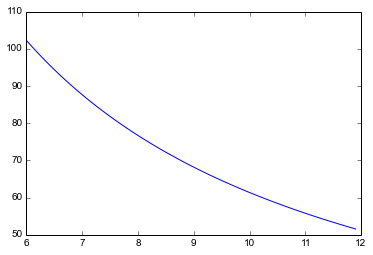

In [24]:
# Here's a plot of how speed changes for a given number of frames
# One frame changes the speed by about 7-8 mph
#
x = arange(6, 12, 0.1)
y = quick_and_dirty(x)
plot(x,y)
print 8, quick_and_dirty(8)
print 9, quick_and_dirty(9)
print 10, quick_and_dirty(10)

55 80.3571428571
60 87.6623376623
65 94.9675324675


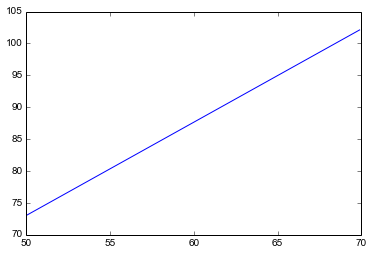

In [25]:
# And a plot of how speed changes as we change our distance estimate,
# for a given number of frames.
#
# At 7 frames, a difference of 5 feet in the distance estimate
# means a difference of 7 mph
#
x = arange(50, 70, 0.1)
y = quick_and_dirty(7, feet=x)
plot(x,y)
print 55, quick_and_dirty(7, feet=55)
print 60, quick_and_dirty(7, feet=60)
print 65, quick_and_dirty(7, feet=65)


In [26]:
import math

In [27]:
math.sqrt(math.pow(60.0, 2.0) + math.pow(13.5, 2.0))

61.5

In [28]:
13.5 / 1.5

9.0

In [29]:
60 / 1.5

40.0

In [30]:
90 * 5280 / 3600.0 / 30 

4.4

In [31]:
# Murali's formula to calculate initial velocity, from 
# http://donthireddy.us/tennis/speed.html

import math
# published numbers  from a now dead link
KNOWN_SERVE_SPEED= 120.
KNOWN_SPEED_AT_BOUNCE= 87.0
DISTANCE_TRAVELED=60.

# A constant for formula:
K= math.log(120./87)/60

def init_speed(nf, d=60, fps=29.97):
    speed = ( math.exp(K*d) - 1) / (5280.*K * nf) * fps * 3600
    return round(speed*100)/100

def avg_speed(nf, d=60, fps=29.97):
    speed = d / (nf / fps ) * (3600./5280.)
    return round(speed*100)/100

#for nf in range(11,18):
#    print init_speed(nf), avg_speed(nf)

#def compare(frames, actual, distance, fps):
#    print frames, actual, init_speed(frames, d=distance, fps=fps), avg_speed(frames, d=distance, fps=fps)

#     frames  actual   estimate
print      9,     79,  init_speed(9,   d=61.5, fps=15.), avg_speed(9,   d=61.5, fps=15.)
print     10,     77,  init_speed(10,  d=61.5, fps=15.), avg_speed(10,  d=61.5, fps=15.)
print    6.5,     95,  init_speed(6.5, d=60.,  fps=15.), avg_speed(6.5, d=60.,  fps=15.)
print      7,     95,  init_speed(7,   d=60.,  fps=15.), avg_speed(7,   d=60.,  fps=15.)




9 79 82.78 69.89
10 77 74.5 62.9
6.5 95 111.35 94.41
7 95 103.4 87.66


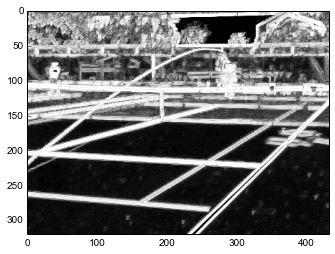

In [32]:
# Create a single grayscale image where for each pixel you figure out the
# median brightness in the entire video for that pixel.  Then in your
# image, your pixel color is the brightness that is most different
# from the median.

# Increase contrast to make the non-zero pixels show up stronger.
contrast = 5

def diff_median(frames, start, end):
    # convert a portion of the video to grayscale
    gray = array([cv2.cvtColor(frames[ii], cv2.COLOR_RGB2GRAY)
                  for ii in xrange(start, end)])
    # Find medians across the video segment
    medians = numpy.median(gray, 0)
    # take differences
    diffs = gray - medians
    # for each pixel, keep only the greatest difference from the median
    abses = numpy.abs(diffs)
    maxes = (1.0-((1.0-numpy.max(abses, 0)/numpy.max(abses))**contrast))
    pylab.imshow(maxes)
    

start_frame = 29*30
end_frame = 36*30
diff_median(frames, start_frame,end_frame)

In [33]:
contrast = 5

def diff_filtered_median(frames, start, end, clean = False):
    # convert a portion of the video to grayscale
    gray = array([cv2.cvtColor(frames[ii], cv2.COLOR_RGB2GRAY)
                  for ii in xrange(start, end)])
    # Find medians across the video segment
    medians = numpy.median(gray, 0)
    
    # Figure out where noise from camera movement happens.
    # This is a hack.  The court lines are different from their neighbors.
    fmeds = numpy.abs(medians-scipy.signal.medfilt2d(medians,21))
    
    # Need to "smooth" to push out the lines.
    smooth = 3
    fmeds = scipy.signal.convolve2d(fmeds, numpy.ones([smooth,smooth])/(smooth*smooth), mode="same")
    # Convert to filter (mark as 1 non line pixels and 0 for line pixels)
    level = 0.05
    fmeds = fmeds/numpy.max(fmeds)
    
    
    fmeds[fmeds<level] = 0.0
    fmeds[fmeds>=level] = 1.0
    
    # Take differences
    diffs = gray - medians
    # For each pixel, keep only the greatest difference from the median
    abses = numpy.abs(diffs)
    maxes = (1.0-((1.0-numpy.max(abses, 0)/numpy.max(abses))**contrast))*(1-fmeds)
    
    if clean:
    # Just the top points.
        maxes[maxes<0.3] = 0.0
    
    pylab.imshow(fmeds)
    pylab.figure()
    pylab.imshow(maxes)


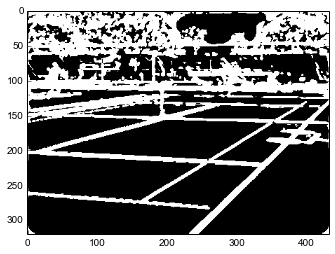

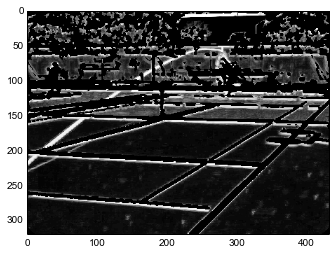

In [34]:
diff_filtered_median(frames, start_frame, end_frame)
#figure()
#diff_filtered_median(frames, 90,110)
#figure()
#diff_filtered_median(frames, 160, 170)

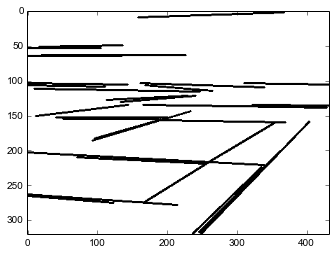

In [35]:
# Get lines via Hough Transform
smooth = 3

def smooth2d(im, smooth = smooth):
    return cv2.erode(im, ones((smooth, smooth)))

def plot_hough_lines(im, aperture=3):  
    if len(im.shape) > 2:
        gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        
    else:
        gray = uint8(im)
   
    kernel = numpy.ones((smooth, smooth))/(smooth*smooth)
    edges = cv2.filter2D(cv2.Canny(gray,50,150, aperture), -1, kernel)
   
    
    #lines = cv2.HoughLines(edges,1,np.pi/180,200)
  #  imshow(edges)
  #  figure()
    bl = ones(gray.shape)
    imshow(bl)
    
    
    minLineLength = 90
    maxLineGap = 0
    lines = cv2.HoughLinesP(edges,3,np.pi/180,100,maxLineGap,minLineLength)
    ll = map(lambda(x) : x[0], lines)
    for x1,y1,x2,y2 in ll:
        cv2.line(bl, (x1,y1),(x2,y2), (0,255,0),2)
    
  #  for rho,theta in lines[0]:
  #      a = np.cos(theta)
  #      b = np.sin(theta)
  #      x0 = a*rho
  #      y0 = b*rho
  #      x1 = int(x0 + 1000*(-b))
  #      y1 = int(y0 + 1000*(a))
  #      x2 = int(x0 - 1000*(-b))
  #      y2 = int(y0 - 1000*(a))
        
  #      print (((x1,y1),(x2,y2)))
        #plot(((x1,y1),(x2,y2)))
    
    return bl

lines = plot_hough_lines(frames[ii])
imshow(lines)

In [2]:
def match(desc1,desc2): 
    """ For each descriptor in the first image, select its match in the second image. 
    input: desc1 (descriptors for the first image), desc2 (same for second image). """
    desc1 = array([d/linalg.norm(d) for d in desc1]) 
    desc2 = array([d/linalg.norm(d) for d in desc2])
    dist_ratio = 0.6 
    desc1_size = desc1.shape
    matchscores = zeros(desc1_size[0],1)
    desc2t = desc2.T 
    # precompute matrix transpose 
    for i in range(desc1_size[0]): 
        dotprods = dot(desc1[i,:],desc2t) 
        # vector of dot products 
        dotprods = 0.9999*dotprods 
        # inverse cosine and sort, return index for features in second image 
        indx = argsort(arccos(dotprods))
        # check if nearest neighbor has angle less than dist_ratio times 2nd 
        if arccos(dotprods)[indx[0]] < dist_ratio * arccos(dotprods)[indx[1]]: 
            matchscores[i] = int(indx[0])
    return matchscores

def match_twosided(desc1,desc2): 
    """ Two-sided symmetric version of match(). """
    matches_12 = match(desc1,desc2) 
    matches_21 = match(desc2,desc1)
    ndx_12 = matches_12.nonzero()[0]
    # remove matches that are not symmetric 
    for n in ndx_12: 
        if matches_21[int(matches_12[n])] != n: 
            matches_12[n] = 0
    return matches_12



def sift_align(im1, im2):
    if len(im1.shape) == 3:
        gray1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
    else:
        gray1 = uint8(im1)
        
    if len(im2.shape) == 3:
        gray2 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
    else:
        gray2 = uint8(im2)
        
    sift = cv2.xfeatures2d.SIFT_create()
    kp1 = sift.detect(gray1)
    kp2 = sift.detect(gray2)
    imshow(im1)
    figure()
    scatter(x = [kk.pt[0] for kk in kp1], y=[kk.pt[1] for kk in kp1], c='r', s=4)
   
        

    return [x.pt for x in kp1]              
    
kk = sift_align(frames[ii], frames[ii+1])
    

NameError: name 'frames' is not defined

In [4]:
1+2+3+4+5+6+7+8+9+10

55